# ARID1A proteomics cis comparison

## Step 1: Library Imports

Run this cell to import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re
import sys 
sys.path.append('C:\\Users\\brittany henderson\\GitHub\\WhenMutationsMatter\\Brittany\\')
import functions as f

import cptac
import cptac.algorithms as al

## Step 2: Find the frequently mutated genes for Endometrial Cancer

Enter the type of cancer and the cutoff for mutation frequency that you would like to use.

In [2]:
en_object = cptac.Endometrial()
desired_cutoff = .1

endometrial_freq_mut = al.get_frequently_mutated(en_object, cutoff = desired_cutoff)
print('\n\nNumber of Frequently Mutated Genes:', len(endometrial_freq_mut), '\n', endometrial_freq_mut.head())

                                    

Number of Frequently Mutated Genes: 232 
      Gene  Unique_Samples_Mut  Missence_Mut  Truncation_Mut
0  ABCA12            0.147368      0.094737        0.073684
1  ABCA13            0.115789      0.105263        0.042105
2  ACVR2A            0.105263      0.010526        0.094737
3  ADGRG4            0.136842      0.126316        0.021053
4  ADGRV1            0.115789      0.094737        0.052632


## Step 3: Select ARID1A, a frequently mutated gene

In [3]:
gene = 'ARID1A'

## Step 4: Select phosphoproteomics

In [65]:
omics = en_object.get_phosphoproteomics()

omics_and_mutations = en_object.join_omics_to_mutations(
        mutations_genes = gene, omics_df_name = 'phosphoproteomics', omics_genes = gene)

## Step 5: cis comparison 

Determine if the DNA mutation has an effect on the omics measurement. In order to do this, we have a few steps in code. These steps are found in the format_cis_comparison_data function.
1. get a table with both the omics and mutation data for tumors
2. get a binary column from the mutation data to separate our samples
3. format data frame to be used in the T-test
4. send data to the T-test.

The format_cis_comparison_data does the first 3 steps.

In [48]:
# filter for gene
col_regex = gene + "-.*"
gene_df = omics.filter(regex=col_regex)

In [47]:
# Step 2 - create binary column
omics_and_mutations['binary_mutations'] = omics_and_mutations[gene+'_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else 'Mutated')
tumors = omics_and_mutations.loc[omics_and_mutations['Sample_Status'] == 'Tumor'] #drop Normal samples

# Step 3 - format
bin_mut = tumors['binary_mutations'] # binary column for tumors
phos_df = gene_df.join(bin_mut, how = 'right') # joins to the tumors by joining right

In [81]:
print("Doing t-test comparison for mutation status\n")
pval_df = pd.DataFrame()
for col_label, content in gene_df.items():
    omics_col_list = [col_label] #list of column name
    
    
    content_df = content.to_frame().dropna() #drop missing phospho measurements 
    existing_measurements = content_df.join(bin_mut, how = 'inner')#joins binary column to index of actual measurements
    phsph_tumors = existing_measurements.dropna(axis = 0) #drop Normal samples
    check_binary = len(phsph_tumors['binary_mutations'].unique()) == 2
    
    if (len(phsph_tumors.index) != 0) & check_binary:
        significant_pval_results = al.wrap_ttest(phsph_tumors, 'binary_mutations', omics_col_list)
        pval_df = pval_df.append(significant_pval_results, ignore_index = True)
    if(col_label == gene_df.columns[-1:]):
        print(pval_df)

Doing t-test comparison for mutation status

No significant comparisons.
No significant comparisons.
No significant comparisons.
No significant comparisons.
No significant comparisons.
No significant comparisons.
No significant comparisons.
No significant comparisons.
No significant comparisons.
No significant comparisons.
No significant comparisons.
No significant comparisons.
No significant comparisons.
No significant comparisons.
No significant comparisons.
No significant comparisons.
      Comparison       P_Value
0   ARID1A-S1182  5.517951e-03
1   ARID1A-S1184  4.338936e-07
2   ARID1A-S1600  3.103462e-04
3   ARID1A-S1602  1.163528e-02
4   ARID1A-S1604  1.501846e-06
5   ARID1A-S1751  1.897477e-04
6   ARID1A-S1755  7.963747e-10
7    ARID1A-S363  3.402219e-05
8    ARID1A-S604  4.944088e-03
9    ARID1A-S607  1.301296e-02
10   ARID1A-S610  7.141617e-03
11   ARID1A-S696  1.869464e-04
12   ARID1A-S698  8.216899e-03
13   ARID1A-S702  5.568366e-04
14    ARID1A-S79  4.585671e-02
15  ARID1A-

In [76]:
genes = pval_df['Comparison']
genes

0     ARID1A-S1182
1     ARID1A-S1184
2     ARID1A-S1600
3     ARID1A-S1602
4     ARID1A-S1604
5     ARID1A-S1751
6     ARID1A-S1755
7      ARID1A-S363
8      ARID1A-S604
9      ARID1A-S607
10     ARID1A-S610
11     ARID1A-S696
12     ARID1A-S698
13     ARID1A-S702
14      ARID1A-S79
15    ARID1A-T1206
16     ARID1A-T377
17    ARID1A-Y1339
Name: Comparison, dtype: object

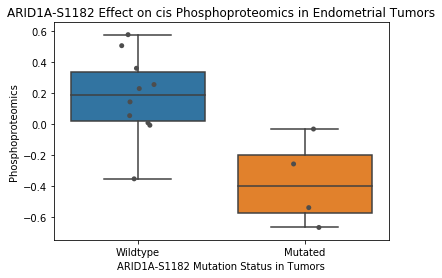

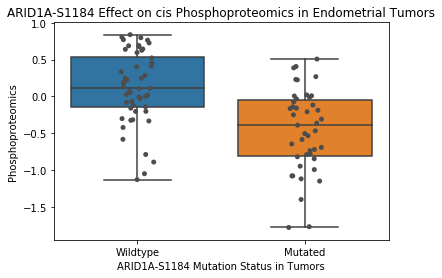

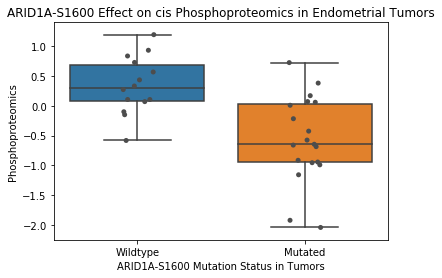

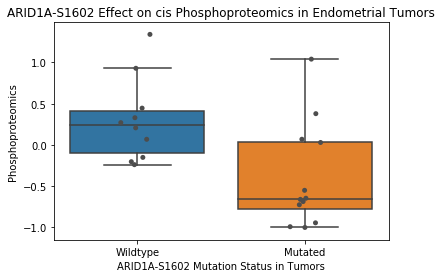

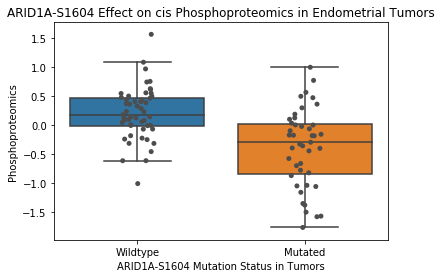

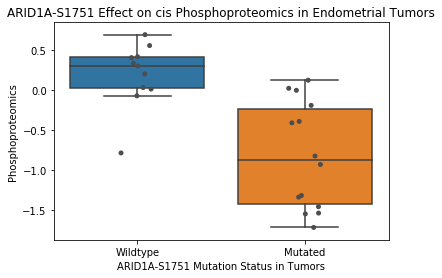

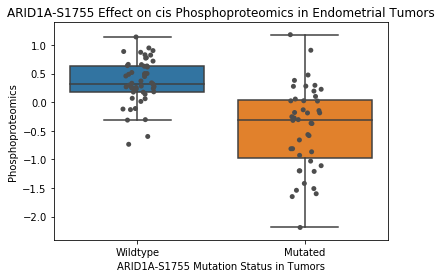

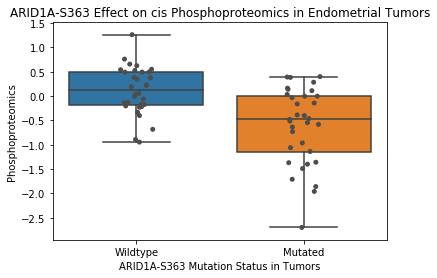

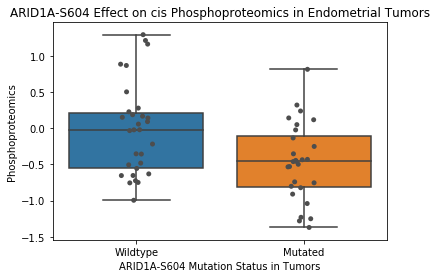

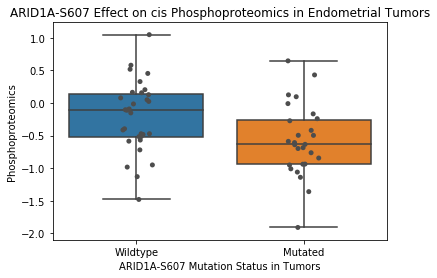

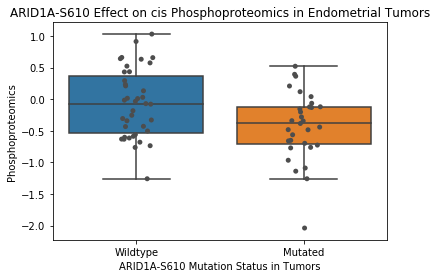

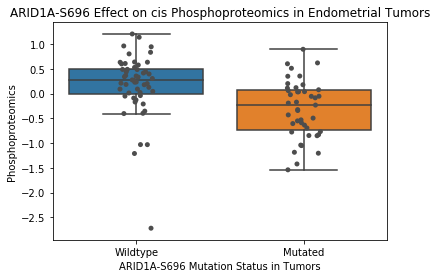

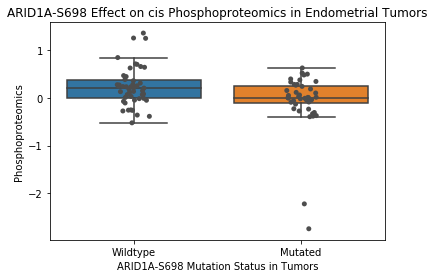

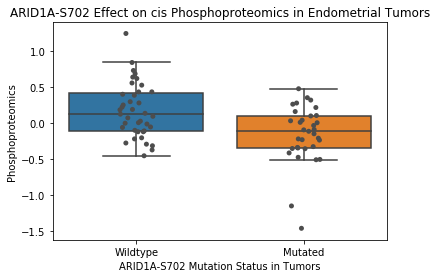

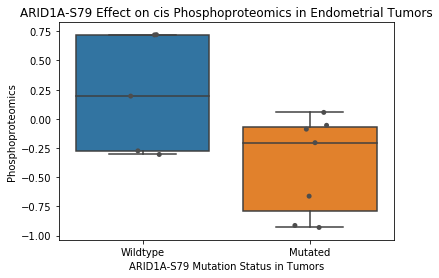

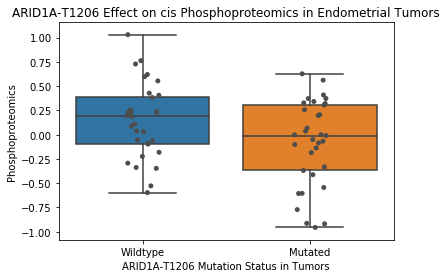

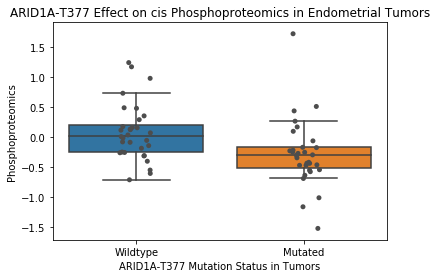

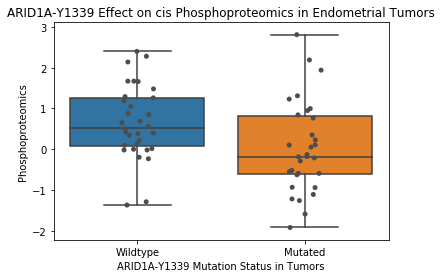

In [78]:
for gene in genes:
    # Step 5 - Create boxplt to compare wildtype and mutated effect on omics data
    en_cis_boxplot = sns.boxplot(data = tumors, x = 'binary_mutations',
                              y = gene+'_phosphoproteomics' , order = ["Wildtype","Mutated"], showfliers = False)  
    en_cis_boxplot.set_title(gene + " Effect on cis Phosphoproteomics in Endometrial Tumors")
    en_cis_boxplot = sns.stripplot(data= tumors, x = 'binary_mutations',
                                y = gene+'_phosphoproteomics',jitter = True, color = ".3", order = ["Wildtype","Mutated"])
    en_cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Phosphoproteomics")
    plt.show()

In [ ]:
en_type = f.get_missence_truncation_comparison(en_object, omics, 'proteomics', gene)
#print(mutation_type_comparison.head())

# T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutation type\n")
significant_pval_results = al.wrap_ttest(en_type, 'binary_mutations', omics_col_list)
print(significant_pval_results)

# Step 5 - Create boxplt to compare mutation type effect on omics data
en_cis_boxplot = sns.boxplot(data = en_type, x = 'binary_mutations',
                          y = prot_col, order = ["Missence","Truncation"], showfliers = False)  
en_cis_boxplot.set_title(gene + " Mutation Type Effect on cis Proteomics in Endometrial Tumors")
en_cis_boxplot = sns.stripplot(data= en_type, x = 'binary_mutations',
                            y = prot_col,jitter = True, color = ".3", order = ["Missence","Truncation"])
en_cis_boxplot.set(xlabel = gene + " Mutation Type", ylabel = 'Proteomics')
plt.show()

# Repeat with the Colon dataset

Go through the same process, this time using the Colon dataset. We will only print five genes from the frequently mutated data frame for simplicity.

In [ ]:
colon_object = cptac.Colon()
desired_cutoff = .1

colon_freq_mut = al.get_frequently_mutated(colon_object, cutoff = desired_cutoff)
print('\n\nNumber of Frequently Mutated Genes:', len(colon_freq_mut), '\n', colon_freq_mut.head())

In [ ]:
gene = 'ARID1A'

co_omics = colon_object.get_proteomics()

In [ ]:
co_status = f.format_cis_comparison_data(colon_object, co_omics, 'proteomics', gene)
#co_data_for_comparison.head()

print("Doing t-test comparison for mutation type\n")
significant_pval_results = al.wrap_ttest(co_status, 'binary_mutations', omics_col_list)
print(significant_pval_results)

cis_boxplot = sns.boxplot(data = co_status, x = 'binary_mutations',
                          y = prot_col, order = ["Wildtype","Mutated"], showfliers = False)  
cis_boxplot.set_title(gene + " Effect on cis Proteomics in Colon Tumors")
cis_boxplot = sns.stripplot(data = co_status, x = 'binary_mutations',
                            y = prot_col, jitter = True, color = ".3", 
                            order = ["Wildtype","Mutated"])
cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
plt.show()

In [ ]:
co_type = f.get_missence_truncation_comparison(colon_object, co_omics, 'proteomics', gene)

print("Doing t-test comparison for mutation type\n")
significant_pval_results = al.wrap_ttest(co_type, 'binary_mutations', omics_col_list)
print(significant_pval_results)


co_cis_boxplot = sns.boxplot(data = co_type, x = 'binary_mutations',
                          y = prot_col, order = ["Missence","Truncation"], showfliers = False)  
co_cis_boxplot.set_title(gene + " Mutation Type Effect on cis Proteomics in Colon Tumors")
co_cis_boxplot = sns.stripplot(data= co_type, x = 'binary_mutations',
                            y = prot_col,jitter = True, color = ".3", order = ["Missence","Truncation"])
co_cis_boxplot.set(xlabel = gene + " Mutation Type", ylabel = 'Proteomics')
plt.show()

# Repeat with the Ovarian dataset


In [ ]:
ovarian_object = cptac.Ovarian()
desired_cutoff = .1

ovarian_freq_mut = al.get_frequently_mutated(ovarian_object, cutoff = desired_cutoff)

In [ ]:
ov_omics = ovarian_object.get_proteomics()
gene = 'ARID1A'

In [ ]:
ov_status = f.format_cis_comparison_data(ovarian_object, ov_omics, 'proteomics', gene)

print("Doing t-test comparison for mutation status\n")
significant_pval_results = al.wrap_ttest(ov_status, 'binary_mutations', omics_col_list)
print(significant_pval_results)

ov_cis_boxplot = sns.boxplot(data = ov_status, x = 'binary_mutations',
                          y = prot_col, order = ["Wildtype","Mutated"], showfliers = False)  
ov_cis_boxplot.set_title(gene + " Effect on cis Proteomics in Ovarian Tumors")
ov_cis_boxplot = sns.stripplot(data = ov_status, x = 'binary_mutations',y = prot_col, jitter = True, 
                        color = ".3", order = ["Wildtype","Mutated"])
ov_cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
plt.show()


In [ ]:
ov_type = f.get_missence_truncation_comparison(ovarian_object, ov_omics, 'proteomics', gene)

print("Doing t-test comparison for mutation type\n")
significant_pval_results = al.wrap_ttest(ov_type, 'binary_mutations', omics_col_list)
print(significant_pval_results)

ov_cis_boxplot = sns.boxplot(data = ov_type, x = 'binary_mutations',
                          y = prot_col, order = ["Missence","Truncation"], showfliers = False)  
ov_cis_boxplot.set_title(gene + " Mutation Type Effect on cis Proteomics in Ovarian Tumors")
ov_cis_boxplot = sns.stripplot(data= ov_type, x = 'binary_mutations',
                            y = prot_col,jitter = True, color = ".3", order = ["Missence","Truncation"])
ov_cis_boxplot.set(xlabel = gene + " Mutation Type", ylabel = 'Proteomics')

# Visualize Pancancer effects

In [ ]:
# Create a dataframe with pancancer data for mutation status and type
en_mut_status = en_status.assign(Cancer= 'Endo')
co_mut_status = co_status.assign(Cancer= 'Colon')
ov_mut_status = ov_status.assign(Cancer= 'Ovarian')
en_mut_type = en_type.assign(Cancer= 'Endo')
co_mut_type = co_type.assign(Cancer= 'Colon')
ov_mut_type = ov_type.assign(Cancer= 'Ovarian')

pancancer_data = pd.concat([en_mut_status, co_mut_status, ov_mut_status, en_mut_type, co_mut_type, ov_mut_type]) 
pancancer_df = pd.melt(pancancer_data, id_vars=['Cancer','binary_mutations'], value_name= 'Proteomics')  

# Visualize mutation status (mutated vs wildtype) accross cancers
plt.rcParams['figure.figsize']=(14,8) #size of plot
cis_status = sns.boxplot(x='Cancer', y="Proteomics", hue = 'binary_mutations', 
                         hue_order = ['Wildtype', 'Mutated'], data=pancancer_df, showfliers = False)    
cis_status.set_title('Pancancer ' + gene + " Mutation Status Effect on Proteomics Abundance")
cis_status = sns.stripplot(x='Cancer', y="Proteomics", hue = 'binary_mutations', data=pancancer_df,
                            jitter = True, color = ".3", hue_order = ['Wildtype', 'Mutated'], dodge = True)
cis_status.set(xlabel = gene + " Mutation Status", ylabel = 'Proteomics')

plt.show()

plt.clf()
plt.close()

# Visualize mutation status (missense vs truncation) accross cancers
plt.rcParams['figure.figsize']=(14,8) #size of plot
cis_status = sns.boxplot(x='Cancer', y="Proteomics", hue = 'binary_mutations', 
                         hue_order = ['Wildtype', 'Missence', 'Truncation'], data = pancancer_df, showfliers = False)    
cis_status.set_title('Pancancer ' + gene + " Mutation Type Effect on Proteomics Abundance")
cis_status = sns.stripplot(x='Cancer', y="Proteomics", hue = 'binary_mutations', data = pancancer_df, jitter = True, 
                           color = ".3", hue_order = ['Wildtype', 'Missence', 'Truncation'], dodge = True)
cis_status.set(xlabel = gene + " Mutation Type", ylabel = 'Proteomics')

plt.show()

plt.clf()
plt.close()

# Analysis of Results

Endometrial and colon tumors showed decreased proteomics abundance for the tumors with the mutated gene compared to the wildtype, with endometrial tumors showing the most difference.
All other results were insignificant. Since the ovarian dataset only contains four mutated data points, it is possible that more data collection may show that ovarian cancer follows the same trend.